<a href="https://colab.research.google.com/github/anurags1904/Healthcare-Diagnosis-System/blob/main/Healthcare_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All datasets loaded successfully!

 Displaying Data Visualizations...


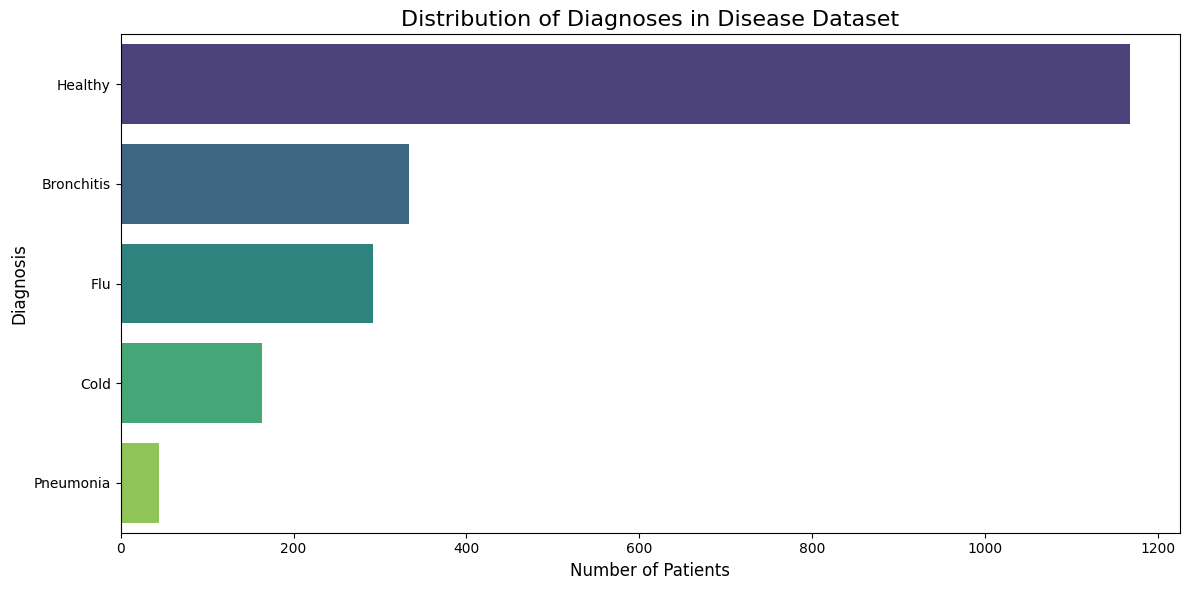

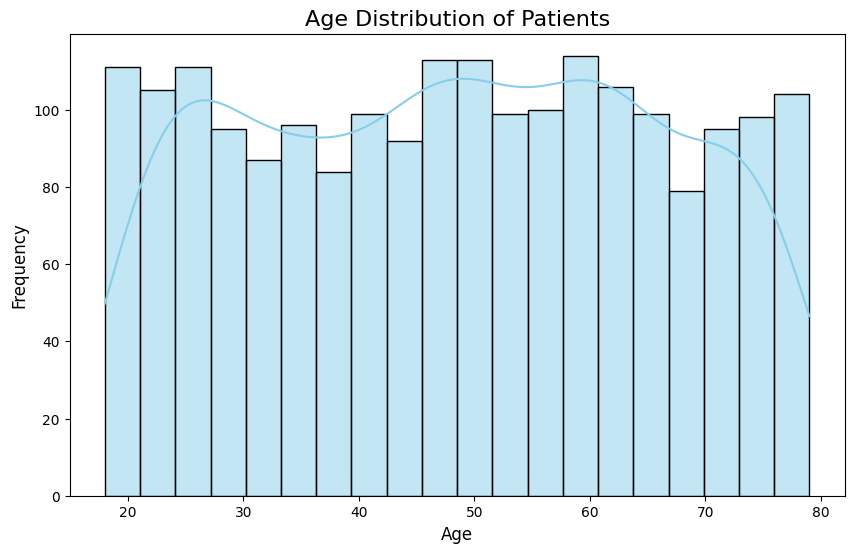

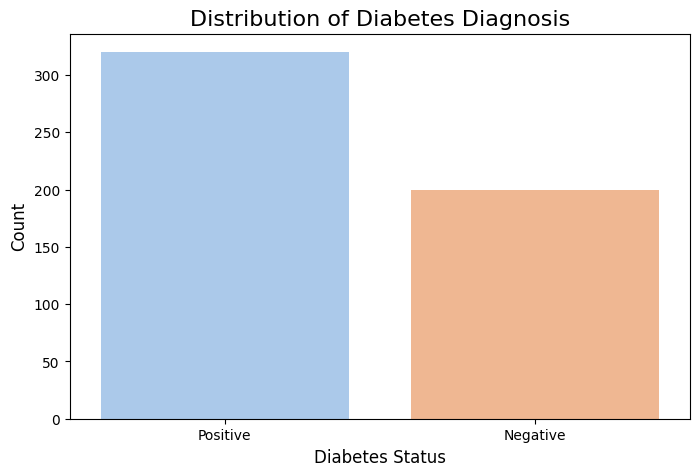


 Training machine learning models...
 Disease prediction model trained.
 Diabetes prediction model trained.

 Saving models and data processors...

 Setup complete. You can now run the health_checkup.py script.


In [1]:
# ==========================================
# AI-Powered Health Diagnosis System (Part 1: Training)
# ==========================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

# ==========================================
# STEP 1: Load all datasets
# ==========================================

try:
    disease_df = pd.read_csv("disease_diagnosis.csv")
    diabetes_df = pd.read_csv("diabetes_data_upload.xls")
    healthcare_df = pd.read_csv("healthcare_dataset.csv")
    print("All datasets loaded successfully!")

    # This flag will be used to check if loading was successful
    datasets_loaded = True

except FileNotFoundError as e:
    print(f"Error loading datasets: {e}. Please make sure all CSV files are in the correct directory.")
    # Set the flag to false if any file is not found
    datasets_loaded = False

# --- This block now only runs if all datasets were loaded successfully ---
if datasets_loaded:
    # ==========================================
    # STEP 2: Clean Data & Visualize Insights
    # ==========================================

    # --- Preprocess Disease Dataset ---
    disease_df_clean = disease_df.copy()
    for col in ['Gender', 'Diagnosis', 'Severity', 'Symptom_1', 'Symptom_2', 'Symptom_3']:
        disease_df_clean[col] = disease_df_clean[col].astype(str).str.strip().str.title()
    disease_df_clean[['Systolic', 'Diastolic']] = disease_df_clean['Blood_Pressure_mmHg'].str.split('/', expand=True).astype(float)
    disease_df_clean.drop(columns=['Blood_Pressure_mmHg', 'Patient_ID', 'Treatment_Plan'], inplace=True)

    # --- Preprocess Diabetes Dataset ---
    diabetes_df_clean = diabetes_df.copy()
    for col in diabetes_df_clean.columns:
        if diabetes_df_clean[col].dtype == 'object':
            diabetes_df_clean[col] = diabetes_df_clean[col].str.strip().str.title()

    print("\n Displaying Data Visualizations...")

    # --- Plot 1: Distribution of Diagnoses ---
    plt.figure(figsize=(12, 6))
    sns.countplot(y='Diagnosis', data=disease_df_clean, order = disease_df_clean['Diagnosis'].value_counts().index, palette='viridis')
    plt.title('Distribution of Diagnoses in Disease Dataset', fontsize=16)
    plt.xlabel('Number of Patients', fontsize=12)
    plt.ylabel('Diagnosis', fontsize=12)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Age Distribution ---
    plt.figure(figsize=(10, 6))
    sns.histplot(disease_df_clean['Age'], bins=20, kde=True, color='skyblue')
    plt.title('Age Distribution of Patients', fontsize=16)
    plt.xlabel('Age', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()

    # --- Plot 3: Diabetes Class Distribution ---
    plt.figure(figsize=(8, 5))
    sns.countplot(x='class', data=diabetes_df_clean, palette='pastel')
    plt.title('Distribution of Diabetes Diagnosis', fontsize=16)
    plt.xlabel('Diabetes Status', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.show()

    # ==========================================
    # STEP 3: Train Machine Learning Models
    # ==========================================

    print("\n Training machine learning models...")

    # --- Disease Model Training ---
    gender_encoder = LabelEncoder().fit(['Male', 'Female'])
    symptom_cols = ['Symptom_1', 'Symptom_2', 'Symptom_3']
    all_symptoms = pd.concat([disease_df_clean[col] for col in symptom_cols]).unique()
    symptom_encoder = LabelEncoder().fit(all_symptoms)
    disease_df_clean['Gender'] = gender_encoder.transform(disease_df_clean['Gender'])
    for col in symptom_cols:
        disease_df_clean[col] = symptom_encoder.transform(disease_df_clean[col])
    X_disease = disease_df_clean.drop(columns=['Diagnosis', 'Severity'])
    y_disease = disease_df_clean['Diagnosis']
    disease_model = RandomForestClassifier(random_state=42)
    disease_model.fit(X_disease, y_disease)
    print(" Disease prediction model trained.")

    # --- Diabetes Model Training ---
    diabetes_encoders = {}
    for col in diabetes_df_clean.columns:
        if diabetes_df_clean[col].dtype == 'object':
            le = LabelEncoder()
            diabetes_df_clean[col] = le.fit_transform(diabetes_df_clean[col])
            diabetes_encoders[col] = le
    X_diabetes = diabetes_df_clean.drop(columns=['class'])
    y_diabetes = diabetes_df_clean['class']
    diabetes_model = RandomForestClassifier(random_state=42)
    diabetes_model.fit(X_diabetes, y_diabetes)
    print(" Diabetes prediction model trained.")

    # ==========================================
    #  STEP 4: Save Models and Encoders for Later Use
    # ==========================================

    print("\n Saving models and data processors...")
    joblib.dump(disease_model, 'disease_model.joblib')
    joblib.dump(diabetes_model, 'diabetes_model.joblib')
    joblib.dump(gender_encoder, 'gender_encoder.joblib')
    joblib.dump(symptom_encoder, 'symptom_encoder.joblib')
    joblib.dump(diabetes_encoders, 'diabetes_encoders.joblib')
    joblib.dump(list(X_diabetes.columns), 'diabetes_features.joblib')

    # Clean and save the healthcare dataframe for context
    healthcare_df['Medical Condition'] = healthcare_df['Medical Condition'].str.title()
    healthcare_df['Medication'] = healthcare_df['Medication'].str.title()
    healthcare_df.to_csv('healthcare_context.csv', index=False)

    print("\n Setup complete. You can now run the health_checkup.py script.")

else:
    print("\nScript halted because one or more data files could not be loaded.")


In [ ]:
# ==========================================
# AI-Powered Health Diagnosis System (Part 2: Checkup)
# ==========================================

import pandas as pd
import numpy as np
from IPython.display import display, HTML
import warnings
import joblib

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

# ==========================================
# STEP 1: Load Pre-trained Models and Data
# ==========================================

try:
    disease_model = joblib.load('disease_model.joblib')
    diabetes_model = joblib.load('diabetes_model.joblib')
    gender_encoder = joblib.load('gender_encoder.joblib')
    symptom_encoder = joblib.load('symptom_encoder.joblib')
    diabetes_encoders = joblib.load('diabetes_encoders.joblib')
    diabetes_features = joblib.load('diabetes_features.joblib')
    healthcare_df = pd.read_csv("healthcare_context.csv")
    print(" Pre-trained models and data loaded successfully!")

    models_loaded = True

except FileNotFoundError as e:
    print(f" Error: {e}. Please run the model_training.py script first to generate the necessary files.")
    models_loaded = False

# ==========================================
#  STEP 2: Comprehensive Interactive Health Checkup
# ==========================================
if models_loaded:
    def health_checkup():
        print("\n" + "="*45)
        print("🩺 Comprehensive Health Checkup Form (User Test)")
        print("="*45)

        # --- Descriptions for Diabetes Symptoms ---
        diabetes_symptom_descriptions = {
            'Polyuria': "Excessive or abnormally large production or passage of urine?",
            'Polydipsia': "Excessive thirst or excess drinking?",
            'Sudden Weight Loss': "Any sudden, unexplained weight loss?",
            'Weakness': "A general feeling of weakness or lack of energy?",
            'Polyphagia': "Excessive hunger or increased appetite?",
            'Genital Thrush': "A yeast infection in the genital area?",
            'Visual Blurring': "Is your vision blurry or out of focus?",
            'Itching': "Persistent itching of the skin?",
            'Irritability': "Feeling more irritable or agitated than usual?",
            'Delayed Healing': "Do cuts, sores, or bruises take a long time to heal?",
            'Partial Paresis': "Partial paralysis or muscle weakness in parts of your body?",
            'Muscle Stiffness': "Unusual stiffness in your muscles?",
            'Alopecia': "Noticeable hair loss or thinning?",
            'Obesity': "Are you considered medically obese?"
        }

        try:
            # --- Part 1: General Information ---
            print("\n--- Part 1: General Vitals & Symptoms ---")
            age = int(input("Enter your Age: "))
            gender = input("Enter your Gender (Male/Female): ").title()
            s1 = input("Enter your main Symptom (e.g., Fever): ").title()
            s2 = input("Enter a second Symptom (e.g., Cough): ").title()
            s3 = input("Enter a third Symptom (e.g., Headache): ").title()
            heart = float(input("Enter your Heart Rate (bpm): "))
            temp = float(input("Enter your Body Temperature (°C): "))
            bp = input("Enter your Blood Pressure (e.g., 120/80): ")
            oxygen = float(input("Enter your Oxygen Saturation (%): "))
            systolic, diastolic = map(float, bp.split('/'))

            def safe_encode(encoder, value, description):
                if value not in encoder.classes_:
                    print(f" Note: '{value}' is an unrecognized {description}. Prediction may be less accurate.")
                    return -1
                return encoder.transform([value])[0]

            # --- Part 2: Diabetes Risk Assessment ---
            print("\n--- Part 2: Diabetes Risk Assessment (Answer Yes/No) ---")
            diabetes_input = {'Age': age, 'Gender': gender}
            for col in diabetes_features:
                if col not in ['Age', 'Gender']:
                    col_name_formatted = col.replace('_', ' ').title()
                    question = diabetes_symptom_descriptions.get(col_name_formatted, f"Do you experience '{col_name_formatted}'?")
                    answer = input(f"{question} ").title()
                    diabetes_input[col] = answer

            # --- Make Predictions ---
            sample_disease = pd.DataFrame([{'Age': age, 'Gender': safe_encode(gender_encoder, gender, 'gender'), 'Symptom_1': safe_encode(symptom_encoder, s1, 'symptom'), 'Symptom_2': safe_encode(symptom_encoder, s2, 'symptom'), 'Symptom_3': safe_encode(symptom_encoder, s3, 'symptom'), 'Heart_Rate_bpm': heart, 'Body_Temperature_C': temp, 'Oxygen_Saturation_%': oxygen, 'Systolic': systolic, 'Diastolic': diastolic}])
            disease_pred = disease_model.predict(sample_disease)[0]

            sample_diabetes = pd.DataFrame([diabetes_input])
            for col, encoder in diabetes_encoders.items():
                if col in sample_diabetes.columns:
                    sample_diabetes[col] = sample_diabetes[col].apply(lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1)
            diabetes_pred_encoded = diabetes_model.predict(sample_diabetes)[0]
            diabetes_pred = diabetes_encoders['class'].inverse_transform([diabetes_pred_encoded])[0]

            if disease_pred == 'Healthy' and temp > 38.5:
                if 'Fever' in [s1, s2, s3]:
                    disease_pred = 'Flu'
                    print("\nℹ NOTE: Initial model prediction was 'Healthy', but overridden to 'Flu' by a clinical rule due to high fever.")

            if temp > 39 or oxygen < 92:
                severity, advice = "Severe", "This could be serious. Please seek immediate medical attention."
            elif temp > 38 or oxygen < 95:
                severity, advice = "Moderate", "Monitor your symptoms closely. Consider consulting a doctor if they don't improve."
            else:
                severity, advice = "Mild", "Stay hydrated and get plenty of rest. Monitor your condition."

            context_info = ""
            matched_patients = healthcare_df[healthcare_df['Medical Condition'] == disease_pred]
            if not matched_patients.empty:
                common_meds = matched_patients['Medication'].mode().tolist()
                context_info = f"<p><b>Contextual Insights:</b> For patients diagnosed with <b>{disease_pred}</b>, common medications include: <b>{', '.join(common_meds)}</b>.</p>"

            report_html = f"""
            <div style='font-family: Arial, sans-serif; border: 2px solid #007BFF; padding: 20px; border-radius: 10px; background-color: #f8f9fa; max-width: 650px; margin: auto;'>
                <h2 style='color: #0056b3; border-bottom: 2px solid #0056b3; padding-bottom: 10px;'>🩺 Comprehensive AI Health Report</h2>
                <h3 style='color: #007BFF;'>Primary Diagnosis</h3>
                <p><b>Predicted Condition:</b> <span style='font-weight: bold; font-size: 1.1em;'>{disease_pred}</span></p>
                <p><b>Assessed Severity:</b> <span style='font-weight: bold; color: {"#dc3545" if severity=="Severe" else "#ffc107" if severity=="Moderate" else "#28a745"};'>{severity}</span></p>
                {context_info}
                <h3 style='color: #007BFF;'>Diabetes Risk Assessment</h3>
                <p><b>Potential Diabetes Status:</b> <span style='font-weight: bold; color: {"#dc3545" if diabetes_pred=="Positive" else "#28a745"};'>{diabetes_pred}</span></p>
                <hr style='border: 1px solid #dee2e6; margin: 20px 0;'>
                <h3 style='color: #007BFF;'>Your Vitals</h3>
                <p><b>Body Temperature:</b> {temp} °C | <b>Oxygen Saturation:</b> {oxygen}%</p>
                <p><b>Blood Pressure:</b> {systolic}/{diastolic} mmHg | <b>Heart Rate:</b> {heart} bpm</p>
                <div style='background-color: #e9ecef; padding: 15px; border-radius: 8px; margin-top: 20px;'>
                    <p style='color: #495057; font-weight: bold;'>Disclaimer & Advice:</p>
                    <p style='color: #495057;'>This is an AI-generated report, not a substitute for professional medical advice. Our recommendation is: <b>{advice}</b></p>
                </div>
            </div>
            """
            display(HTML(report_html))

        except ValueError:
            print("\n Invalid input. Please make sure you enter numbers for age, vitals, and blood pressure in the correct format (e.g., 120/80).")
        except Exception as e:
            print(f"\n An unexpected error occurred: {e}")

    # ==========================================
    #  STEP 3: Run System
    # ==========================================
    if __name__ == '__main__':
        health_checkup()
